2.  **Question 2:** Classify the subject ('bert' or 'lupo') based on the neural activity patterns.


In [10]:
# --- Cell 1: Imports ---
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import gc 
import re 

# Scikit-learn imports
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay,
                             r2_score, mean_squared_error, mean_absolute_error) 


plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

### Loading in Data

In [13]:
folder_path = "Freiwald_Tsao_faceviews_AM_data_csv"

# Use glob to find all CSV files in the folder
all_csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Check if any files were found
if not all_csv_files:
    print(f"Error: No CSV files found in the folder: {folder_path}")
else:
    print(f"Found {len(all_csv_files)} CSV files to load.")

    # Create an empty list to hold the individual DataFrames
    list_of_dfs = []

    # Loop through the list of found CSV files
    for file_path in all_csv_files:
        try:
            # Read each CSV file into a DataFrame
            df_single = pd.read_csv(file_path)
            # Optional: Add a column to know which file the data came from
            df_single['source_file'] = os.path.basename(file_path)
            # Append the DataFrame to the list
            list_of_dfs.append(df_single)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")

    # Check if any DataFrames were successfully loaded
    if not list_of_dfs:
        print("No dataframes were loaded successfully.")
    else:
        # Concatenate all DataFrames in the list into a single DataFrame
        combined_df = pd.concat(list_of_dfs, axis=0, ignore_index=True)

        # Display info about the combined DataFrame
        print("\n--- Combined DataFrame ---")
        print(f"Total rows: {len(combined_df)}")
        print(combined_df.info())
        print("\nFirst 5 rows of combined data:")
        print(combined_df.head())
        # Optional: Check unique values in key columns again
        # print("\nUnique persons in combined data:", combined_df['labels.person'].unique())
        # print("Unique orientations in combined data:", combined_df['labels.orientation'].unique())
        # (Run this right after creating combined_df)
       

Found 193 CSV files to load.

--- Combined DataFrame ---
Total rows: 206216
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206216 entries, 0 to 206215
Columns: 807 entries, site_info.monkey to source_file
dtypes: int64(802), object(5)
memory usage: 1.2+ GB
None

First 5 rows of combined data:
  site_info.monkey site_info.region  labels.stimID  labels.person  \
0             bert               am              1              1   
1             bert               am              1              1   
2             bert               am              1              1   
3             bert               am              1              1   
4             bert               am              1              1   

  labels.orientation labels.orient_person_combo  time.1_2  time.2_3  time.3_4  \
0              front                    front 1         0         0         0   
1              front                    front 1         0         0         0   
2              front                    front

### Splitting firing rates in each time bins

In [14]:

if 'combined_df' in locals() and not combined_df.empty:
    print("--- Engineering Features: Firing Rates in Bins ---")

    # --- Define Time Bins ---
    bin_size_ms = 50  # 50ms bins
    window_ms = 400   # First 400ms
    n_bins = window_ms // bin_size_ms
    bin_edges = np.arange(0, window_ms + 1, bin_size_ms)
    bin_duration_s = bin_size_ms / 1000.0
    print(f"Using {n_bins} bins of size {bin_size_ms}ms.")

    # --- Identify Time Columns ---
    time_cols_pattern = [f'time.{i}_{i+1}' for i in range(1, window_ms)]
    time_cols_pattern = [col for col in time_cols_pattern if col in combined_df.columns]

    if not time_cols_pattern:
        print("Error: Could not find relevant time columns.")
        X_patterns = pd.DataFrame() # Create empty df
    else:
        # Select spike data - use full combined_df index for now
        spike_data = combined_df[time_cols_pattern]

        # --- Calculate Rates ---
        rate_feature_names = [f'rate_bin_{i*bin_size_ms}_{(i+1)*bin_size_ms}ms' for i in range(n_bins)]
        X_patterns = pd.DataFrame(index=spike_data.index, columns=rate_feature_names, dtype=float)

        print("Calculating firing rates per bin...")
        for i in range(n_bins):
            start_col_idx = bin_edges[i]
            end_col_idx = bin_edges[i+1]
            cols_in_bin = [f'time.{t}_{t+1}' for t in range(start_col_idx + 1, end_col_idx + 1)]
            cols_in_bin = [col for col in cols_in_bin if col in spike_data.columns]

            if cols_in_bin:
                X_patterns[rate_feature_names[i]] = spike_data[cols_in_bin].sum(axis=1) / bin_duration_s
            else:
                X_patterns[rate_feature_names[i]] = 0.0

        # Handle potential NaNs created during calculation (though unlikely here)
        X_patterns.fillna(0.0, inplace=True)

        print("\nFiring rate features calculated.")
        print(f"Shape of pattern features X_patterns: {X_patterns.shape}")
        
else:
     print("Error: 'combined_df' not found or is empty. Cannot create features.")
     X_patterns = pd.DataFrame() # Create empty df

--- Engineering Features: Firing Rates in Bins ---
Using 8 bins of size 50ms.
Calculating firing rates per bin...

Firing rate features calculated.
Shape of pattern features X_patterns: (206216, 8)


## Part 3: Question 2 - Subject Classification

**Task:** Classify the subject ('bert' or 'lupo') based on the neural activity patterns (binned firing rates).

In [16]:


if 'X_patterns' in locals() and not X_patterns.empty:
    print("--- Preparing Data for Q2: Subject Classification ---")
    # Define Target Y (Subject) - Use index from X_patterns for alignment
    Y_subj_raw = combined_df.loc[X_patterns.index, 'site_info.monkey'].copy()
    Y_subj_raw.dropna(inplace=True)
    X_patterns_q2 = X_patterns.loc[Y_subj_raw.index] # Align X to final Y index

    # Encode labels
    label_encoder_q2 = LabelEncoder()
    Y_subj = pd.Series(label_encoder_q2.fit_transform(Y_subj_raw), index=Y_subj_raw.index)
    print(f"Subject label mapping: {dict(zip(label_encoder_q2.classes_, label_encoder_q2.transform(label_encoder_q2.classes_)))}")
    print(f"Target Y (Subject) shape: {Y_subj.shape}")
    print(f"Features X (Patterns) shape: {X_patterns_q2.shape}")


    # Split data
    X_train_q2, X_test_q2, Y_train_q2, Y_test_q2 = train_test_split(
            X_patterns_q2, Y_subj, test_size=0.3, random_state=42, stratify=Y_subj # Stratify by subject
        )
    print(f"\nSplit data for Q2: X_train={X_train_q2.shape}, X_test={X_test_q2.shape}")

    # Scale features
    
    scaler_q2 = StandardScaler()
    X_train_q2_scaled = scaler_q2.fit_transform(X_train_q2)
    X_test_q2_scaled = scaler_q2.transform(X_test_q2)


    

--- Preparing Data for Q2: Subject Classification ---
Subject label mapping: {'bert': 0, 'lupo': 1}
Target Y (Subject) shape: (206216,)
Features X (Patterns) shape: (206216, 8)

Split data for Q2: X_train=(144351, 8), X_test=(61865, 8)



--- Training Logistic Regression for Q2 (Subject) ---

--- Logistic Regression Evaluation (Q2 Subject) ---
Test Accuracy: 0.6759 (Chance Level: 0.50)

Classification Report:
              precision    recall  f1-score   support

        bert       0.68      1.00      0.81     41837
        lupo       0.42      0.00      0.01     20028

    accuracy                           0.68     61865
   macro avg       0.55      0.50      0.41     61865
weighted avg       0.59      0.68      0.55     61865


Confusion Matrix (Q2 Subject):


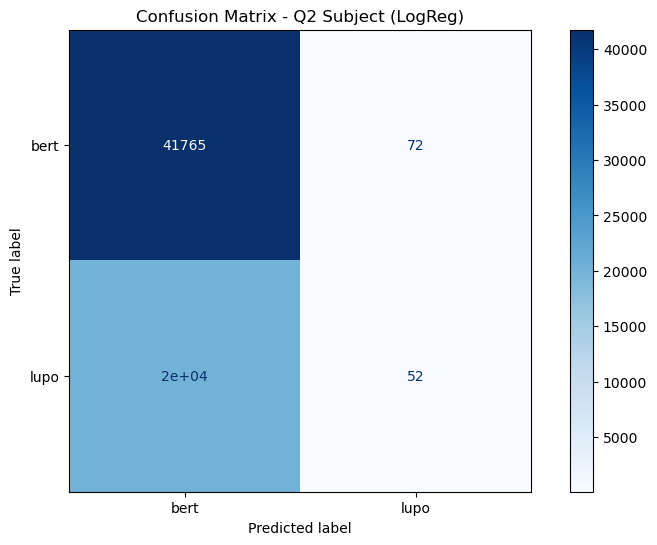

In [5]:
# --- Cell 8: Q2 - Logistic Regression ---

if 'X_train_q2_scaled' in locals(): # Check if Q2 data prep was successful
    print("\n--- Training Logistic Regression for Q2 (Subject) ---")
    logreg_q2 = LogisticRegression(random_state=42, max_iter=1000) # Binary classification

    # Optional: CV on training data
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # cv_scores_q2 = cross_val_score(logreg_q2, X_train_q2_scaled, Y_train_q2, cv=kf, scoring='accuracy', n_jobs=-1)
    # print(f"Mean CV Accuracy (LogReg Q2): {np.mean(cv_scores_q2):.4f} (+/- {np.std(cv_scores_q2):.4f})")

    # Fit model
    logreg_q2.fit(X_train_q2_scaled, Y_train_q2)

    # Predict on test data
    Y_pred_logreg_q2 = logreg_q2.predict(X_test_q2_scaled)

    # Evaluate
    print("\n--- Logistic Regression Evaluation (Q2 Subject) ---")
    accuracy_q2 = accuracy_score(Y_test_q2, Y_pred_logreg_q2)
    # Chance level is 1/2 = 0.50
    print(f"Test Accuracy: {accuracy_q2:.4f} (Chance Level: 0.50)")
    print("\nClassification Report:")
    print(classification_report(Y_test_q2, Y_pred_logreg_q2, target_names=label_encoder_q2.classes_))

    print("\nConfusion Matrix (Q2 Subject):")
    cm_q2 = confusion_matrix(Y_test_q2, Y_pred_logreg_q2)
    disp_q2 = ConfusionMatrixDisplay(confusion_matrix=cm_q2, display_labels=label_encoder_q2.classes_)
    disp_q2.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Q2 Subject (LogReg)')
    plt.show()
else:
    print("Skipping Q2 Logistic Regression: Training data not available.")

In [ ]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from scipy.stats import randint
import matplotlib.pyplot as plt # For confusion matrix plot
import numpy as np # Ensure numpy is imported

print("\n--- Training Tuned Random Forest for Q2 (Subject) ---")

try:
    # Define parameter distribution for Randomized Search
    param_dist_rf_clf = {
        'n_estimators': randint(100, 300),       # Number of trees
        'max_depth': [10, 20, 30, None],        # Max depth
        'min_samples_split': randint(2, 20),    # Min samples to split
        'min_samples_leaf': randint(1, 10),     # Min samples per leaf
        'criterion': ['gini', 'entropy']        # Splitting criterion
    }
    rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

    # Initialize Randomized Search
    # Adjust n_iter or cv if needed for performance
    random_search_rf_clf = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist_rf_clf,
        n_iter=15, # Number of parameter settings sampled (adjust as needed)
        cv=3,      # Use 3-fold CV
        scoring='accuracy', # Optimize for accuracy
        random_state=42,
        n_jobs=-1, # Use all cores for CV folds
        verbose=1  # Show progress
    )

    # Fit Randomized Search on the scaled training data
    print("Starting Randomized Search for Random Forest Classifier...")
    random_search_rf_clf.fit(X_train_q2_scaled, Y_train_q2)

    print(f"Best parameters found: {random_search_rf_clf.best_params_}")
    print(f"Best CV Accuracy score: {random_search_rf_clf.best_score_:.4f}")

    # Evaluate the best estimator found on the test set
    best_rf_clf_q2 = random_search_rf_clf.best_estimator_
    Y_pred_rf_tuned_q2 = best_rf_clf_q2.predict(X_test_q2_scaled)
    accuracy_rf_tuned_q2 = accuracy_score(Y_test_q2, Y_pred_rf_tuned_q2)

    print("\n--- Tuned Random Forest Classifier Evaluation (Q2 Subject) ---")
    print(f"Test Accuracy: {accuracy_rf_tuned_q2:.4f} (Chance Level: 0.50)")
    print("\nClassification Report:")
    print(classification_report(Y_test_q2, Y_pred_rf_tuned_q2, target_names=label_encoder_q2.classes_))

    print("\nConfusion Matrix:")
    cm_rf_q2 = confusion_matrix(Y_test_q2, Y_pred_rf_tuned_q2)
    disp_rf_q2 = ConfusionMatrixDisplay(confusion_matrix=cm_rf_q2, display_labels=label_encoder_q2.classes_)
    disp_rf_q2.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Q2 Subject (Tuned RF)')
    plt.show()

except NameError as e:
    print(f"Error: Ensure necessary variables exist (e.g., X_train_q2_scaled, Y_train_q2, label_encoder_q2): {e}")
except Exception as e:
    print(f"An error occurred during Random Forest training/evaluation: {e}")


--- Training Tuned Random Forest for Q2 (Subject) ---
Starting Randomized Search for Random Forest Classifier...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


--- Calculating Average PSTH ---
Using 50 bins of size 10ms for PSTH.
Plotting Average PSTH...


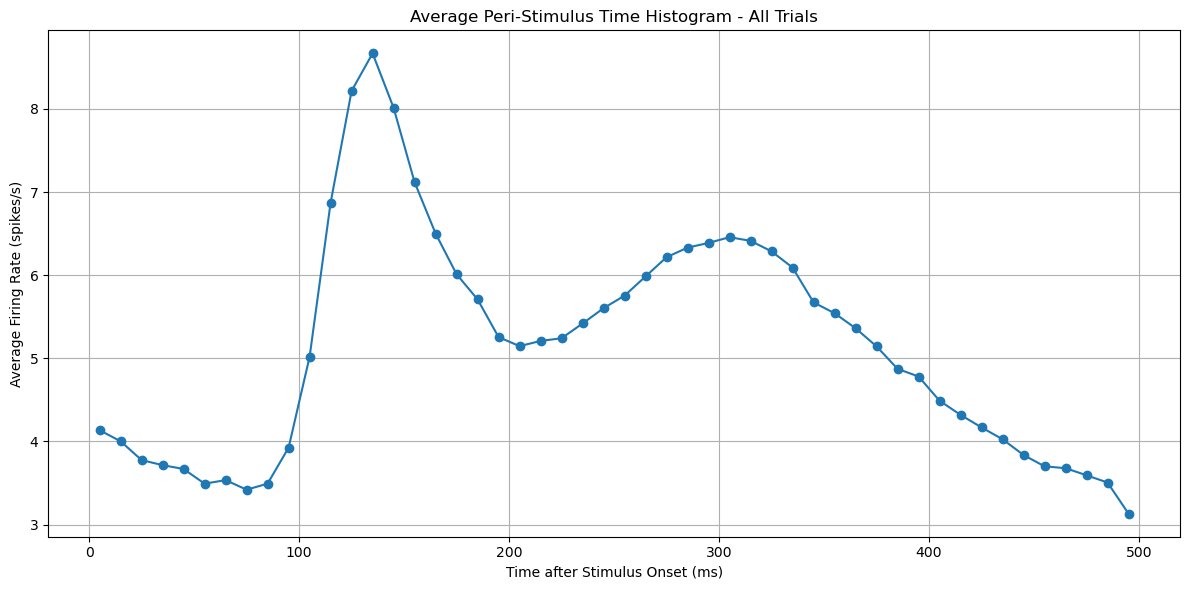

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Calculating Average PSTH ---")

# Ensure combined_df exists
if 'combined_df' not in locals() or combined_df.empty:
    print("Error: 'combined_df' not found or is empty. Please load data first.")
else:
    try:
        # --- Define Time Bins for PSTH ---
        psth_bin_size_ms = 10  # Smaller bins for finer temporal resolution (e.g., 10ms)
        psth_window_ms = 500   # Extend window slightly (e.g., 500ms) to see more dynamics
        psth_n_bins = psth_window_ms // psth_bin_size_ms
        psth_bin_edges = np.arange(0, psth_window_ms + 1, psth_bin_size_ms)
        psth_bin_duration_s = psth_bin_size_ms / 1000.0 # Duration in seconds
        # Calculate bin centers for plotting
        psth_bin_centers = psth_bin_edges[:-1] + (psth_bin_size_ms / 2.0)

        print(f"Using {psth_n_bins} bins of size {psth_bin_size_ms}ms for PSTH.")

        # --- Identify Time Columns needed ---
        time_cols_psth = [f'time.{i}_{i+1}' for i in range(1, psth_window_ms)]
        time_cols_psth = [col for col in time_cols_psth if col in combined_df.columns]

        if not time_cols_psth:
            print("Error: Could not find relevant time columns for PSTH calculation.")
        else:
            # Select only the needed time columns
            spike_data_psth = combined_df[time_cols_psth]

            # --- Calculate Mean Spikes per Bin ---
            mean_spikes_per_bin = np.zeros(psth_n_bins)
            for i in range(psth_n_bins):
                start_col_idx = psth_bin_edges[i]
                end_col_idx = psth_bin_edges[i+1]
                cols_in_bin = [f'time.{t}_{t+1}' for t in range(start_col_idx + 1, end_col_idx + 1)]
                cols_in_bin = [col for col in cols_in_bin if col in spike_data_psth.columns]

                if cols_in_bin:
                    # Calculate the mean spike count in this bin across all trials
                    mean_spikes_per_bin[i] = spike_data_psth[cols_in_bin].sum(axis=1).mean()
                # If no columns, mean_spikes_per_bin[i] remains 0

            # Convert mean spike count to mean firing rate (spikes/sec)
            mean_rate_per_bin = mean_spikes_per_bin / psth_bin_duration_s

            # --- Plotting ---
            print("Plotting Average PSTH...")
            plt.figure(figsize=(12, 6))
            plt.plot(psth_bin_centers, mean_rate_per_bin, marker='o', linestyle='-')
            plt.title('Average Peri-Stimulus Time Histogram - All Trials')
            plt.xlabel('Time after Stimulus Onset (ms)')
            plt.ylabel('Average Firing Rate (spikes/s)')
            plt.grid(True)
            # Add vertical line at stimulus onset if desired (assuming onset is at time 0)
            
          
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"An error occurred during PSTH calculation/plotting: {e}")

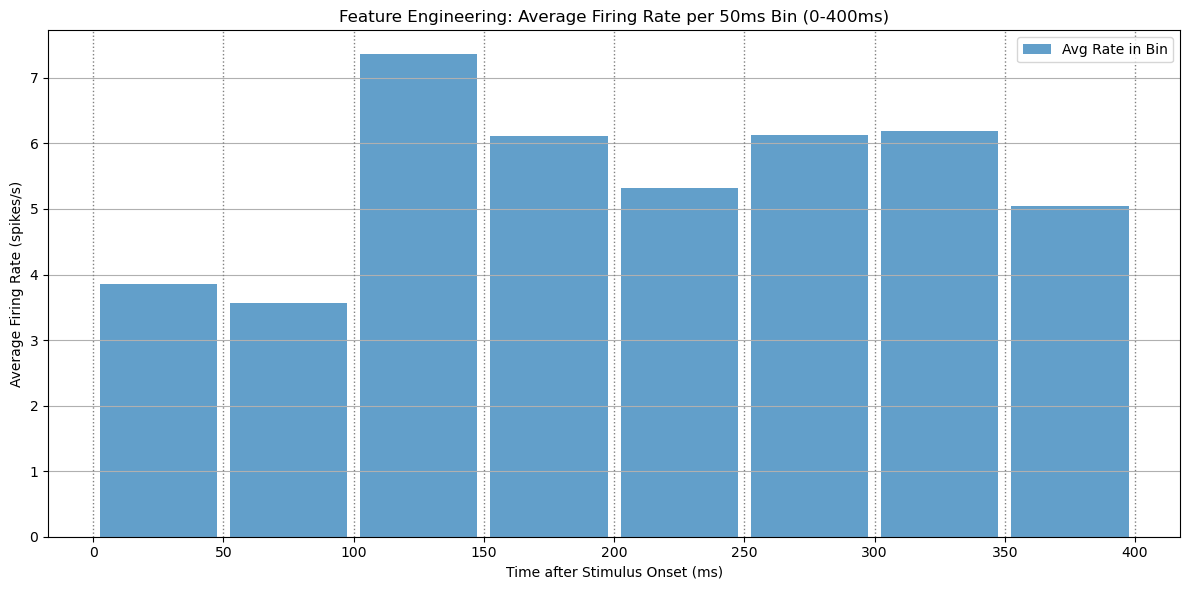

In [17]:

# Check if combined_df exists
if 'combined_df' not in locals() or combined_df.empty:
    print("Error: 'combined_df' not found or is empty. Please load data first.")
else:
    try:
        # --- Define Feature Bins (matching X_patterns) ---
        feature_bin_size_ms = 50
        feature_window_ms = 400
        feature_n_bins = feature_window_ms // feature_bin_size_ms
        feature_bin_edges = np.arange(0, feature_window_ms + 1, feature_bin_size_ms)
        feature_bin_duration_s = feature_bin_size_ms / 1000.0
        feature_bin_centers = feature_bin_edges[:-1] + (feature_bin_size_ms / 2.0)

        # --- Identify Time Columns needed ---
        time_cols_feat = [f'time.{i}_{i+1}' for i in range(1, feature_window_ms)]
        time_cols_feat = [col for col in time_cols_feat if col in combined_df.columns]

        if not time_cols_feat:
            print("Error: Could not find relevant time columns.")
        else:
            spike_data_feat = combined_df[time_cols_feat]

            # --- Calculate Mean Rate per Feature Bin ---
            mean_spikes_per_feat_bin = np.zeros(feature_n_bins)
            for i in range(feature_n_bins):
                start_col_idx = feature_bin_edges[i]
                end_col_idx = feature_bin_edges[i+1]
                cols_in_bin = [f'time.{t}_{t+1}' for t in range(start_col_idx + 1, end_col_idx + 1)]
                cols_in_bin = [col for col in cols_in_bin if col in spike_data_feat.columns]
                if cols_in_bin:
                    mean_spikes_per_feat_bin[i] = spike_data_feat[cols_in_bin].sum(axis=1).mean()

            mean_rate_per_feat_bin = mean_spikes_per_feat_bin / feature_bin_duration_s

            # --- Plotting ---
            plt.figure(figsize=(12, 6))
            # Plot average rate as bars or steps for clarity of bins
            # plt.step(feature_bin_edges[:-1], mean_rate_per_feat_bin, where='post', label='Avg Rate in Bin')
            plt.bar(feature_bin_centers, mean_rate_per_feat_bin, width=feature_bin_size_ms*0.9, label='Avg Rate in Bin', alpha=0.7)

            # Add vertical lines for bin edges
            for edge in feature_bin_edges:
                plt.axvline(edge, color='grey', linestyle=':', linewidth=1)

            plt.title('Feature Engineering: Average Firing Rate per 50ms Bin (0-400ms)')
            plt.xlabel('Time after Stimulus Onset (ms)')
            plt.ylabel('Average Firing Rate (spikes/s)')
            plt.xticks(feature_bin_edges) # Set ticks at bin edges
            plt.grid(axis='y') # Grid lines only on y-axis
            plt.legend()
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"An error occurred during plotting: {e}")